In [1]:
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import math
import random as r
import scipy.stats
import os
import matplotlib.patches as mpatches
from astropy.io import fits
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.neighbors import KernelDensity
from matplotlib.lines import Line2D

In [2]:
sources = pd.read_csv('/home/machado.35/projects/intro/scripts/sources.csv')
sources = list(sources['sources'])

res_list = [60,90,120,150]
fp = '/data/rubin/machado.35/phangs/rand_results/'

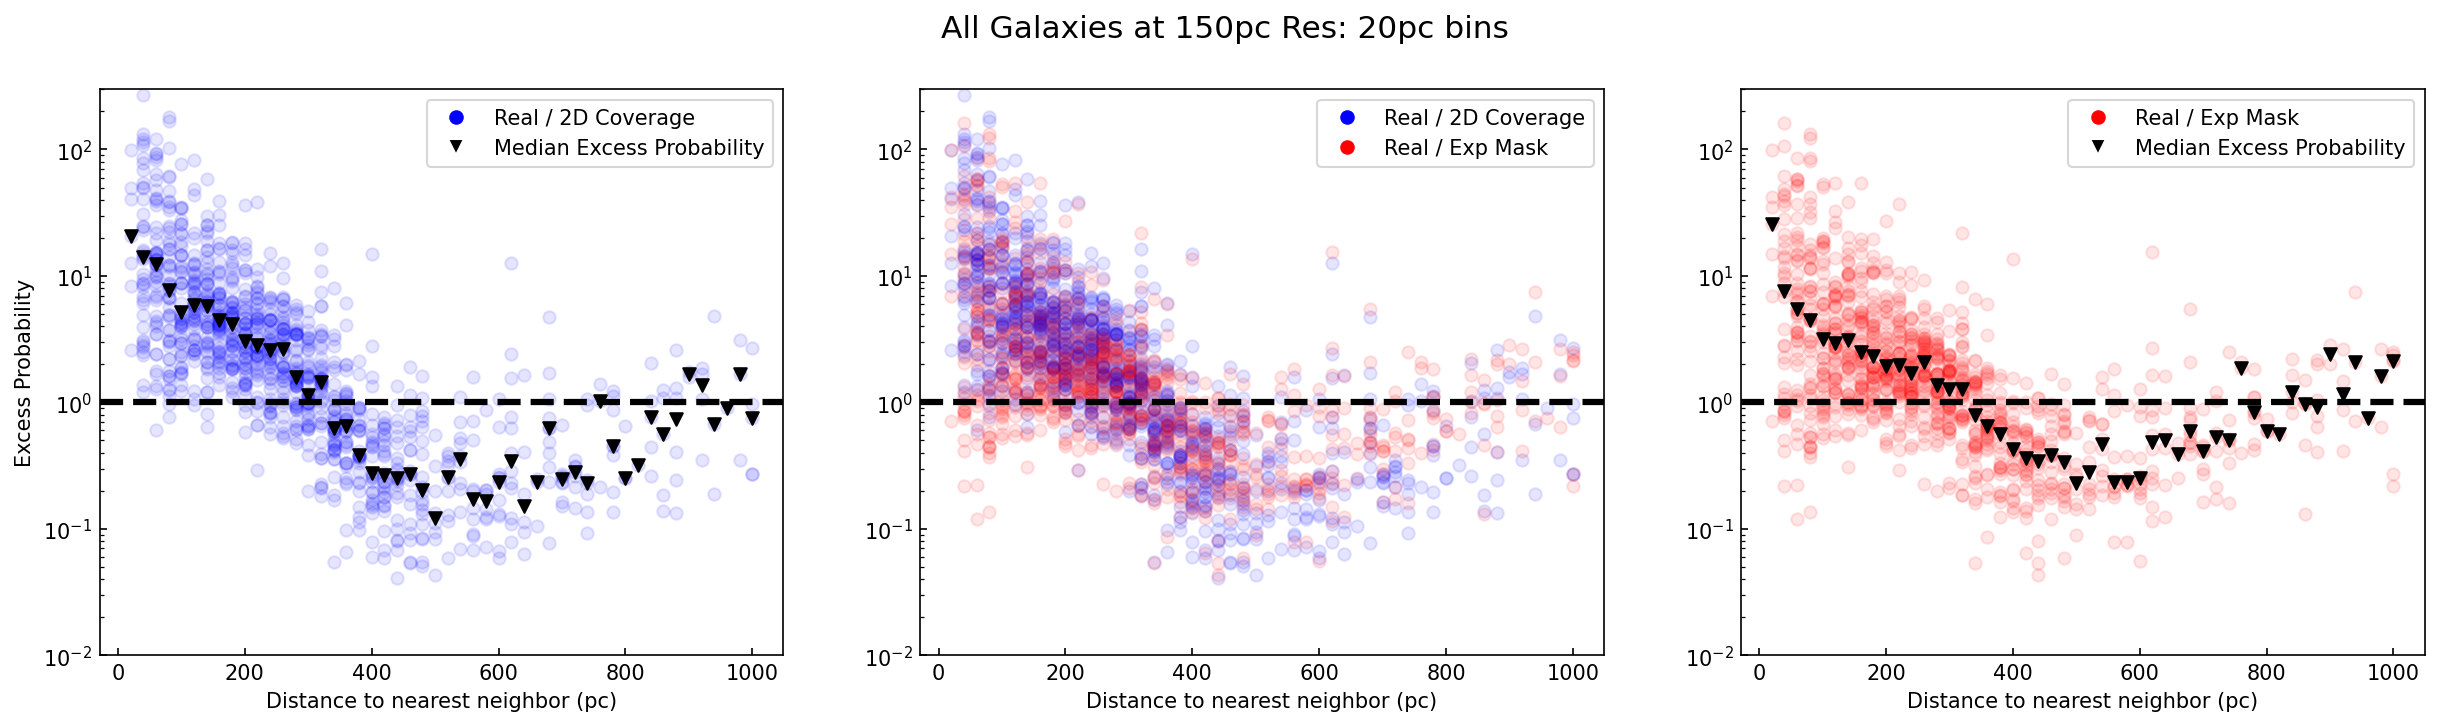

In [3]:
import warnings
warnings.filterwarnings('ignore')
red_patch = mpatches.Patch(color='red', label='Real / Exp Mask')
blue_patch = mpatches.Patch(color='blue', label='Real / 2D Coverage')

res = res_list[3]
bins = np.linspace(0,1000,51)
fig, ax = plt.subplots(1,3, figsize=(20,5), dpi=150)
binsize = bins[1]-bins[0]
cov_median = np.zeros(shape=(len(bins),len(sources)))
exp_median = np.zeros(shape=(len(bins),len(sources)))
cov_med_err = np.zeros(shape=(len(bins),len(sources)))
exp_med_err = np.zeros(shape=(len(bins),len(sources)))

for i in range(len(sources)):
    loc = []
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins, normed=True)
            rand_cov = np.histogram(cov_dist, bins=bins, normed=True)
            rand_exp = np.histogram(exp_dist, bins=bins, normed=True)
            excess_cov = true[0]/rand_cov[0]
            excess_exp = true[0]/rand_exp[0]
            #remove nan and inf
            bad_vals_exp = np.where(np.isfinite(excess_exp) == False)
            bad_vals_cov = np.where(np.isfinite(excess_cov) == False)
            excess_exp[bad_vals_exp] = 0
            excess_cov[bad_vals_cov] = 0
            zeros_exp = np.where(excess_exp == 0)
            zeros_cov = np.where(excess_cov == 0)
            #excess_exp[zeros_exp] = 0.001
            #excess_cov[zeros_cov] = 0.001
            ax[0].scatter(bins[1:], excess_cov, c='b', alpha=0.1)
            ax[2].scatter(bins[1:], excess_exp, c='r', alpha=0.1)
            ax[1].scatter(bins[1:], excess_cov, c='b', alpha=0.1)
            ax[1].scatter(bins[1:], excess_exp, c='r', alpha=0.1)
            for l in range(len(bins[1:])):
                cov_median[l][i] = excess_cov[l]
                exp_median[l][i] = excess_exp[l]


for i in range(len(cov_median[:-1])):
     ax[0].scatter(bins[1:][i], np.median(np.trim_zeros(np.sort(cov_median[i]))), c='black', marker='v')
     ax[2].scatter(bins[1:][i], np.median(np.trim_zeros(np.sort(exp_median[i]))), c='black', marker='v')
    

ax[0].tick_params(axis='both', which='both', direction='in')
ax[1].tick_params(axis='both', which='both', direction='in')
ax[2].tick_params(axis='both', which='both', direction='in')
ax[0].axhline(y=1, color='black', linestyle='--', linewidth=3, label='Equal Prob.')
ax[1].axhline(y=1, color='black', linestyle='--', linewidth=3, label='Equal Prob.')
ax[2].axhline(y=1, color='black', linestyle='--', linewidth=3, label='Equal Prob.')


cov_med_label = Line2D([0], [0], marker='v', color='w', label='Median Excess Probability',
                          markerfacecolor='black', markersize=8)
exp_med_label = Line2D([0], [0], marker='v', color='w', label='Median Excess Probability',
                          markerfacecolor='black', markersize=8)

real_cov = Line2D([0], [0], marker='o', color='w', label='Real / 2D Coverage',
                          markerfacecolor='blue', markersize=8)
real_exp = Line2D([0], [0], marker='o', color='w', label='Real / Exp Mask',
                          markerfacecolor='red', markersize=8)

ax[0].legend(handles=[real_cov, cov_med_label])
ax[1].legend(handles=[real_cov, real_exp])
ax[2].legend(handles=[real_exp, exp_med_label])
ax[0].set_xlabel('Distance to nearest neighbor (pc)')
ax[1].set_xlabel('Distance to nearest neighbor (pc)')
ax[2].set_xlabel('Distance to nearest neighbor (pc)')
ax[0].set_ylabel('Excess Probability')
fig.suptitle('All Galaxies at '+str(res)+'pc Res: '+str(int(np.around(binsize)))+'pc bins', size='15')
ax[0].set_ylim(0.01,300)
ax[0].set_yscale('log')
ax[1].set_ylim(0.01,300)
ax[1].set_yscale('log')
ax[2].set_ylim(0.01,300)
ax[2].set_yscale('log')
plt.show()

In [4]:
def pull_med(x):
    z = np.sort(x)
    z = np.trim_zeros(z)
    return np.median(z)

def trim(x):
    z = np.sort(x)
    z = np.trim_zeros(z)
    return z

Text(0.5, 1.0, 'Median Excess Probability - Exponential')

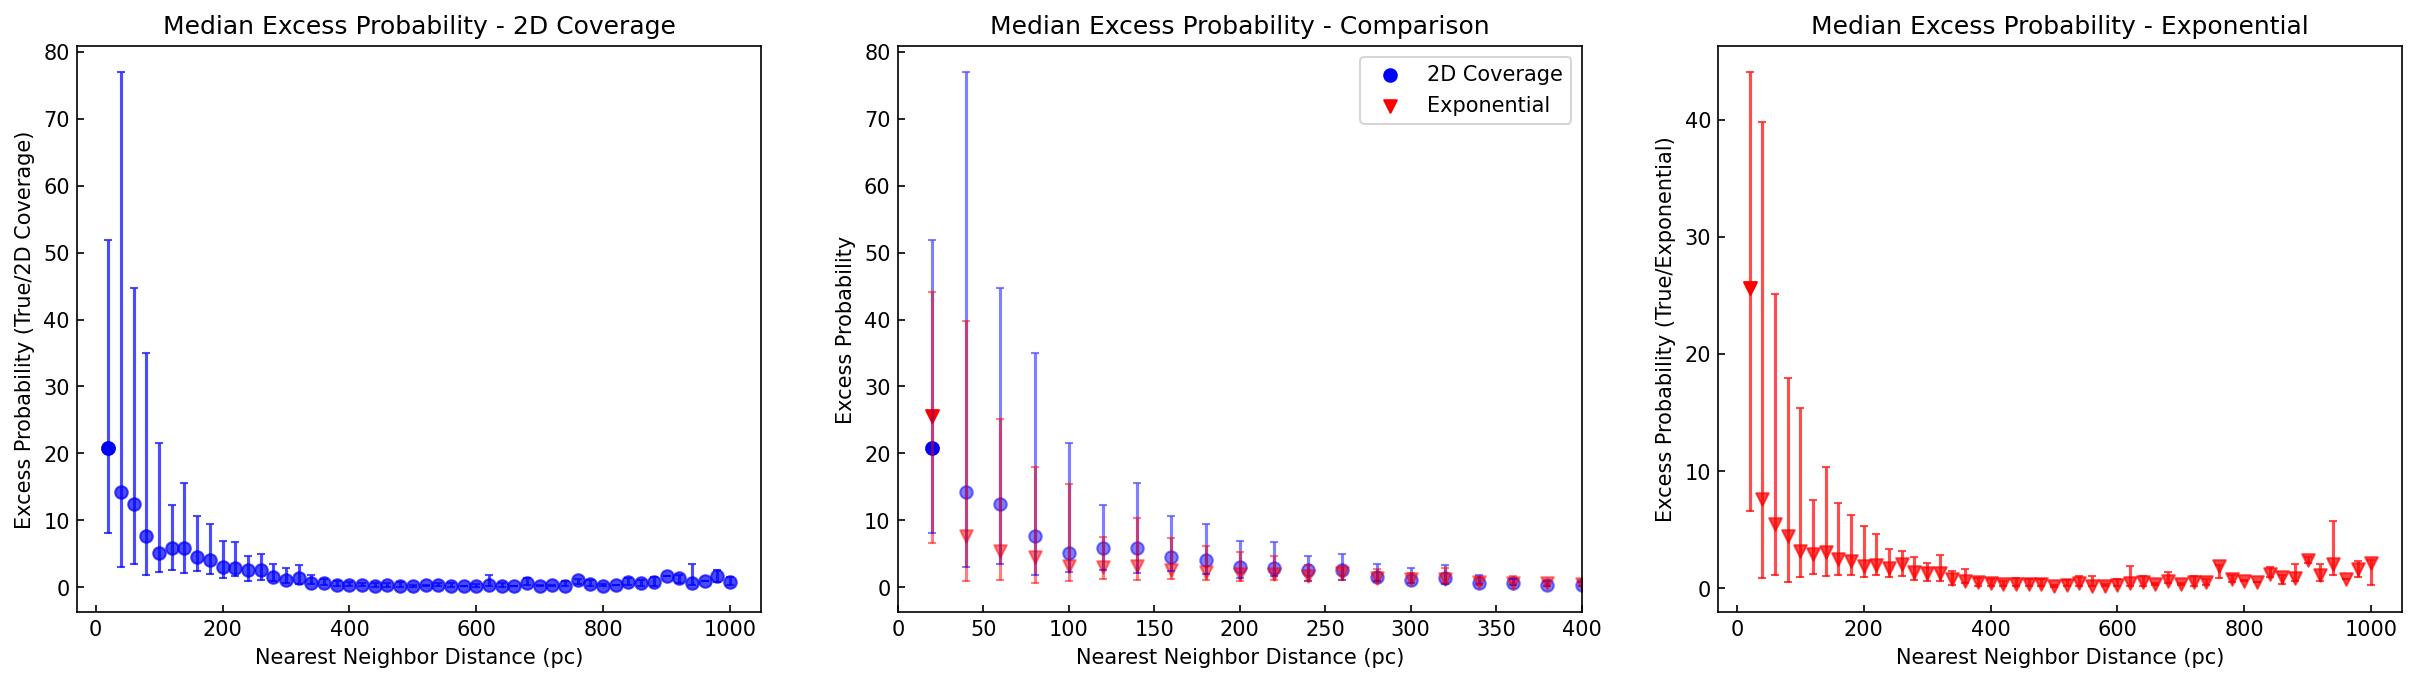

In [5]:
fig, ax = plt.subplots(1,3, figsize=(20,5), dpi=150)
for i in range(len(cov_median[:-1])):
    if i ==0:
        ax[0].scatter(bins[1:][i], pull_med(cov_median[i]), c='blue', label='2D Coverage')
        ax[1].scatter(bins[1:][i], pull_med(cov_median[i]), c='blue', label='2D Coverage')
        ax[1].scatter(bins[1:][i], pull_med(exp_median[i]), c='red', marker='v', label='Exponential')
        ax[2].scatter(bins[1:][i], pull_med(exp_median[i]), c='red', marker='v', label='Exponential')
        
    ax[0].scatter(bins[1:][i], pull_med(cov_median[i]), c='blue', alpha=0.7)
    upper = abs(np.percentile(trim(cov_median[i]), 16)-np.median(trim(cov_median[i])))
    lower = abs(np.percentile(trim(cov_median[i]), 84) - np.median(trim(cov_median[i])))
    yerr = [[upper],[lower]]
    ax[0].errorbar(bins[1:][i], pull_med(cov_median[i]), 
                 yerr=yerr, capsize=2, ecolor='blue', alpha=0.7)
    
    ax[1].scatter(bins[1:][i], pull_med(cov_median[i]), c='blue', alpha=0.5)
    upper = abs(np.percentile(trim(cov_median[i]), 16)-np.median(trim(cov_median[i])))
    lower = abs(np.percentile(trim(cov_median[i]), 84) - np.median(trim(cov_median[i])))
    yerr = [[upper],[lower]]
    ax[1].errorbar(bins[1:][i], pull_med(cov_median[i]), 
                 yerr=yerr, capsize=2, ecolor='blue', alpha=0.5)
    
    ax[1].scatter(bins[1:][i], pull_med(exp_median[i]), c='red', marker='v', alpha=0.5)
    upper = abs(np.percentile(trim(exp_median[i]), 16)-np.median(trim(exp_median[i])))
    lower = abs(np.percentile(trim(exp_median[i]), 84) - np.median(trim(exp_median[i])))
    yerr = [[upper],[lower]]
    ax[1].errorbar(bins[1:][i], pull_med(exp_median[i]), 
                 yerr=yerr, capsize=2, ecolor='red', alpha=0.5)
    
    ax[2].scatter(bins[1:][i], pull_med(exp_median[i]), c='red', marker='v', alpha=0.7)
    upper = abs(np.percentile(trim(exp_median[i]), 16)-np.median(trim(exp_median[i])))
    lower = abs(np.percentile(trim(exp_median[i]), 84) - np.median(trim(exp_median[i])))
    yerr = [[upper],[lower]]
    ax[2].errorbar(bins[1:][i], pull_med(exp_median[i]), 
                 yerr=yerr, capsize=2, ecolor='red', alpha=0.7)

ax[0].set_xlabel('Nearest Neighbor Distance (pc)')
ax[0].set_ylabel('Excess Probability (True/2D Coverage)')
ax[0].tick_params(axis='both', direction='in')
ax[0].set_title('Median Excess Probability - 2D Coverage')
#ax[0].set_yscale('log')
ax[1].set_xlabel('Nearest Neighbor Distance (pc)')
ax[1].set_ylabel('Excess Probability')
ax[1].tick_params(axis='both', direction='in')
ax[1].set_title('Median Excess Probability - Comparison')
ax[1].set_xlim(0,400)
ax[1].legend()

ax[2].set_xlabel('Nearest Neighbor Distance (pc)')
ax[2].set_ylabel('Excess Probability (True/Exponential)')
ax[2].tick_params(axis='both', direction='in')
ax[2].set_title('Median Excess Probability - Exponential')


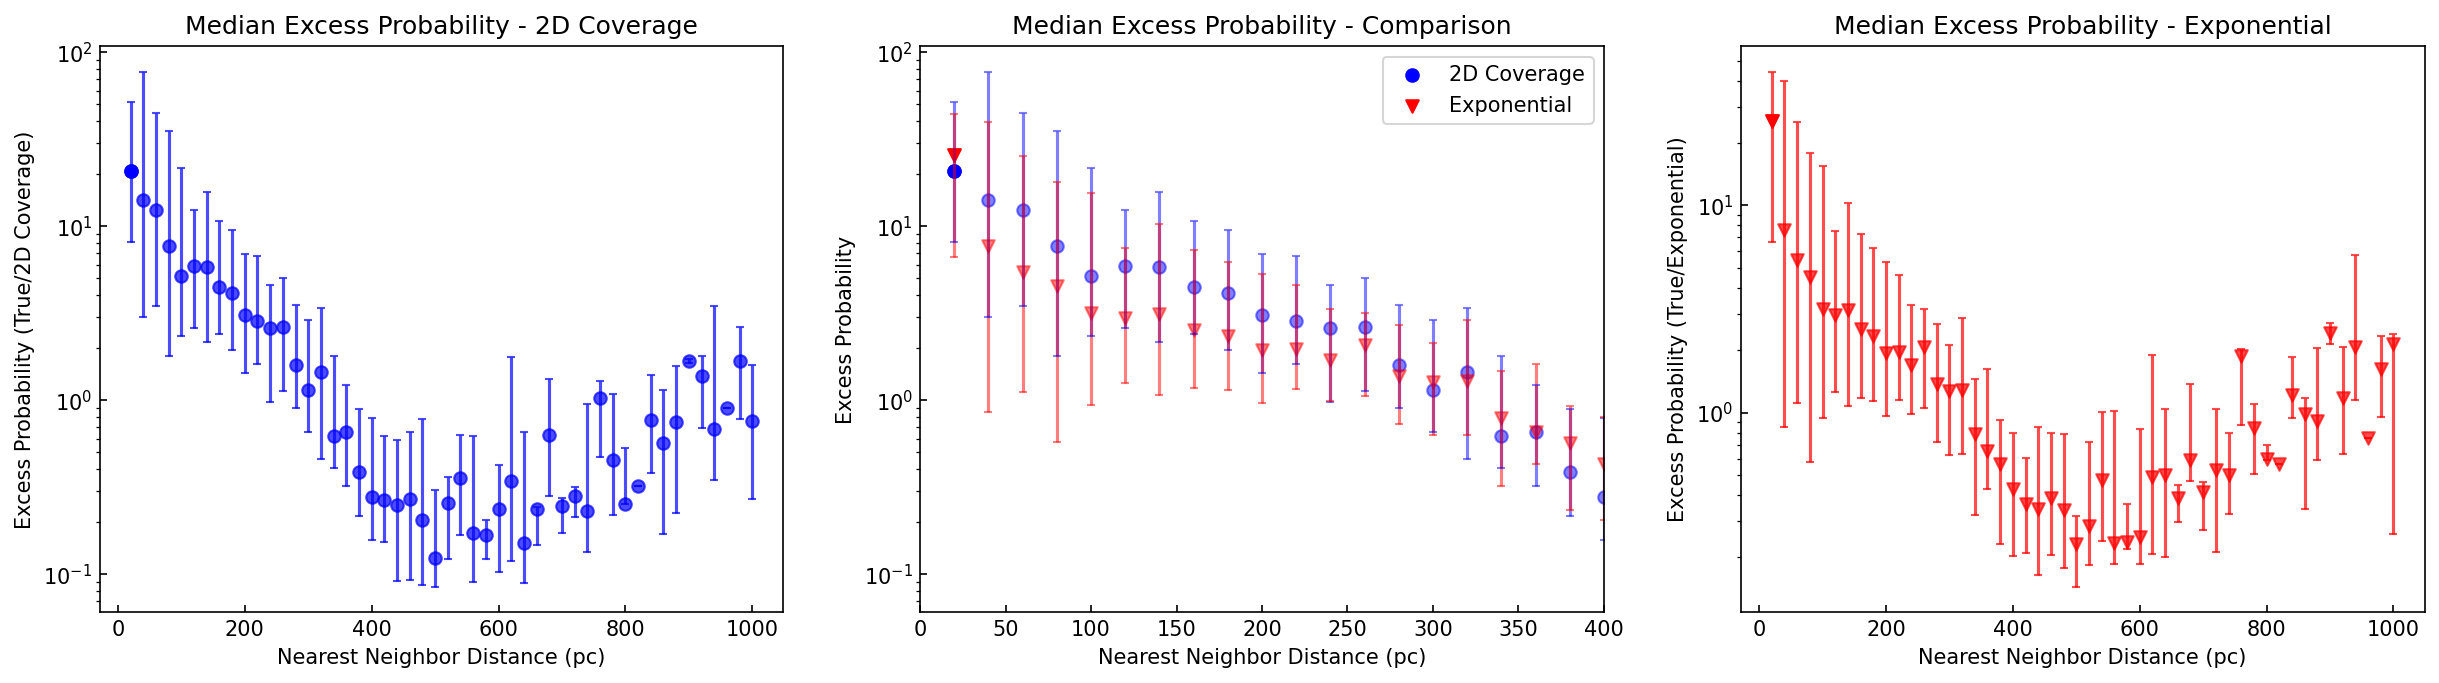

In [6]:
fig, ax = plt.subplots(1,3, figsize=(20,5), dpi=150)
for i in range(len(cov_median[:-1])):
    if i ==0:
        ax[0].scatter(bins[1:][i], pull_med(cov_median[i]), c='blue', label='2D Coverage')
        ax[1].scatter(bins[1:][i], pull_med(cov_median[i]), c='blue', label='2D Coverage')
        ax[1].scatter(bins[1:][i], pull_med(exp_median[i]), c='red', marker='v', label='Exponential')
        ax[2].scatter(bins[1:][i], pull_med(exp_median[i]), c='red', marker='v', label='Exponential')
        
    ax[0].scatter(bins[1:][i], pull_med(cov_median[i]), c='blue', alpha=0.7)
    upper = abs(np.percentile(trim(cov_median[i]), 16)-np.median(trim(cov_median[i])))
    lower = abs(np.percentile(trim(cov_median[i]), 84) - np.median(trim(cov_median[i])))
    yerr = [[upper],[lower]]
    ax[0].errorbar(bins[1:][i], pull_med(cov_median[i]), 
                 yerr=yerr, capsize=2, ecolor='blue', alpha=0.7)
    
    ax[1].scatter(bins[1:][i], pull_med(cov_median[i]), c='blue', alpha=0.5)
    upper = abs(np.percentile(trim(cov_median[i]), 16)-np.median(trim(cov_median[i])))
    lower = abs(np.percentile(trim(cov_median[i]), 84) - np.median(trim(cov_median[i])))
    yerr = [[upper],[lower]]
    ax[1].errorbar(bins[1:][i], pull_med(cov_median[i]), 
                 yerr=yerr, capsize=2, ecolor='blue', alpha=0.5)
    
    ax[1].scatter(bins[1:][i], pull_med(exp_median[i]), c='red', marker='v', alpha=0.5)
    upper = abs(np.percentile(trim(exp_median[i]), 16)-np.median(trim(exp_median[i])))
    lower = abs(np.percentile(trim(exp_median[i]), 84) - np.median(trim(exp_median[i])))
    yerr = [[upper],[lower]]
    ax[1].errorbar(bins[1:][i], pull_med(exp_median[i]), 
                 yerr=yerr, capsize=2, ecolor='red', alpha=0.5)
    
    ax[2].scatter(bins[1:][i], pull_med(exp_median[i]), c='red', marker='v', alpha=0.7)
    upper = abs(np.percentile(trim(exp_median[i]), 16)-np.median(trim(exp_median[i])))
    lower = abs(np.percentile(trim(exp_median[i]), 84) - np.median(trim(exp_median[i])))
    yerr = [[upper],[lower]]
    ax[2].errorbar(bins[1:][i], pull_med(exp_median[i]), 
                 yerr=yerr, capsize=2, ecolor='red', alpha=0.7)

ax[0].set_xlabel('Nearest Neighbor Distance (pc)')
ax[0].set_ylabel('Excess Probability (True/2D Coverage)')
ax[0].tick_params(axis='both', direction='in')
ax[0].set_title('Median Excess Probability - 2D Coverage')
ax[0].set_yscale('log')
ax[1].set_xlabel('Nearest Neighbor Distance (pc)')
ax[1].set_ylabel('Excess Probability')
ax[1].tick_params(axis='both', direction='in')
ax[1].set_title('Median Excess Probability - Comparison')
ax[1].set_xlim(0,400)
ax[1].legend()
ax[1].set_yscale('log')

ax[2].set_xlabel('Nearest Neighbor Distance (pc)')
ax[2].set_ylabel('Excess Probability (True/Exponential)')
ax[2].tick_params(axis='both', direction='in')
ax[2].set_title('Median Excess Probability - Exponential')
ax[2].set_yscale('log')


In [7]:
##PLOT DIFFERENCE IN MEDIAN EXCESS PROBABILITY (EXCESS EXCESS PROBABILITY) VS DISTANCE
## SAME PLOT FOR VARYING BIN WIDTHS
def med_diff(x,y):
    z = x-y
    return z



In [8]:
bins = np.linspace(0,1000,34)
bins

array([   0.        ,   30.3030303 ,   60.60606061,   90.90909091,
        121.21212121,  151.51515152,  181.81818182,  212.12121212,
        242.42424242,  272.72727273,  303.03030303,  333.33333333,
        363.63636364,  393.93939394,  424.24242424,  454.54545455,
        484.84848485,  515.15151515,  545.45454545,  575.75757576,
        606.06060606,  636.36363636,  666.66666667,  696.96969697,
        727.27272727,  757.57575758,  787.87878788,  818.18181818,
        848.48484848,  878.78787879,  909.09090909,  939.39393939,
        969.6969697 , 1000.        ])

Text(0.5, 1.0, 'Excess Probability Difference for Varying Bin Sizes')

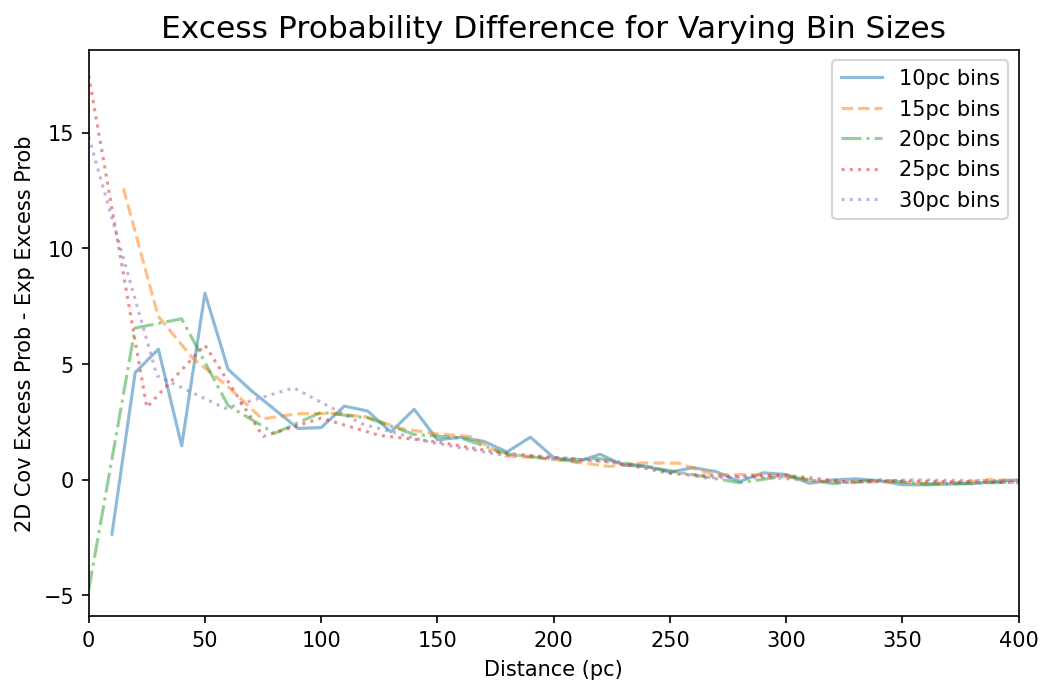

In [9]:
plt.figure(figsize=(8,5), dpi=150)

#10pc bins

res = res_list[3]
bins = np.linspace(0,1000,101)
binsize = bins[1]-bins[0]
cov_median = np.zeros(shape=(len(bins),len(sources)))
exp_median = np.zeros(shape=(len(bins),len(sources)))
cov_med_err = np.zeros(shape=(len(bins),len(sources)))
exp_med_err = np.zeros(shape=(len(bins),len(sources)))

for i in range(len(sources)):
    loc = []
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins, normed=True)
            rand_cov = np.histogram(cov_dist, bins=bins, normed=True)
            rand_exp = np.histogram(exp_dist, bins=bins, normed=True)
            excess_cov = true[0]/rand_cov[0]
            excess_exp = true[0]/rand_exp[0]
            #remove nan and inf
            bad_vals_exp = np.where(np.isfinite(excess_exp) == False)
            bad_vals_cov = np.where(np.isfinite(excess_cov) == False)
            excess_exp[bad_vals_exp] = 0
            excess_cov[bad_vals_cov] = 0
            zeros_exp = np.where(excess_exp == 0)
            zeros_cov = np.where(excess_cov == 0)
            #excess_exp[zeros_exp] = 0.001
            #excess_cov[zeros_cov] = 0.001
            for l in range(len(bins[1:])):
                cov_median[l][i] = excess_cov[l]
                exp_median[l][i] = excess_exp[l]

diff = np.zeros(len(cov_median))
for i in range(len(cov_median)):
    diff[i] = med_diff(pull_med(cov_median[i]), pull_med(exp_median[i]))
plt.plot(bins, diff, alpha=0.5, label='10pc bins', ls='-')


#15pc bins

res = res_list[3]
bins = np.linspace(0,1000,68)
binsize = bins[1]-bins[0]
cov_median = np.zeros(shape=(len(bins),len(sources)))
exp_median = np.zeros(shape=(len(bins),len(sources)))
cov_med_err = np.zeros(shape=(len(bins),len(sources)))
exp_med_err = np.zeros(shape=(len(bins),len(sources)))

for i in range(len(sources)):
    loc = []
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins, normed=True)
            rand_cov = np.histogram(cov_dist, bins=bins, normed=True)
            rand_exp = np.histogram(exp_dist, bins=bins, normed=True)
            excess_cov = true[0]/rand_cov[0]
            excess_exp = true[0]/rand_exp[0]
            #remove nan and inf
            bad_vals_exp = np.where(np.isfinite(excess_exp) == False)
            bad_vals_cov = np.where(np.isfinite(excess_cov) == False)
            excess_exp[bad_vals_exp] = 0
            excess_cov[bad_vals_cov] = 0
            zeros_exp = np.where(excess_exp == 0)
            zeros_cov = np.where(excess_cov == 0)
            #excess_exp[zeros_exp] = 0.001
            #excess_cov[zeros_cov] = 0.001
            for l in range(len(bins[1:])):
                cov_median[l][i] = excess_cov[l]
                exp_median[l][i] = excess_exp[l]

diff = np.zeros(len(cov_median))
for i in range(len(cov_median)):
    diff[i] = med_diff(pull_med(cov_median[i]), pull_med(exp_median[i]))
plt.plot(bins, diff, alpha=0.5, label='15pc bins', ls='--')


#20pc bins

res = res_list[3]
bins = np.linspace(0,1000,51)
binsize = bins[1]-bins[0]
cov_median = np.zeros(shape=(len(bins),len(sources)))
exp_median = np.zeros(shape=(len(bins),len(sources)))
cov_med_err = np.zeros(shape=(len(bins),len(sources)))
exp_med_err = np.zeros(shape=(len(bins),len(sources)))

for i in range(len(sources)):
    loc = []
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins, normed=True)
            rand_cov = np.histogram(cov_dist, bins=bins, normed=True)
            rand_exp = np.histogram(exp_dist, bins=bins, normed=True)
            excess_cov = true[0]/rand_cov[0]
            excess_exp = true[0]/rand_exp[0]
            #remove nan and inf
            bad_vals_exp = np.where(np.isfinite(excess_exp) == False)
            bad_vals_cov = np.where(np.isfinite(excess_cov) == False)
            excess_exp[bad_vals_exp] = 0
            excess_cov[bad_vals_cov] = 0
            zeros_exp = np.where(excess_exp == 0)
            zeros_cov = np.where(excess_cov == 0)
            #excess_exp[zeros_exp] = 0.001
            #excess_cov[zeros_cov] = 0.001
            for l in range(len(bins[1:])):
                cov_median[l][i] = excess_cov[l]
                exp_median[l][i] = excess_exp[l]

diff = np.zeros(len(cov_median))
for i in range(len(cov_median)):
    diff[i] = med_diff(pull_med(cov_median[i]), pull_med(exp_median[i]))
plt.plot(bins, diff, alpha=0.5, label='20pc bins', ls='-.')


#25pc bins

res = res_list[3]
bins = np.linspace(0,1000,41)
binsize = bins[1]-bins[0]
cov_median = np.zeros(shape=(len(bins),len(sources)))
exp_median = np.zeros(shape=(len(bins),len(sources)))
cov_med_err = np.zeros(shape=(len(bins),len(sources)))
exp_med_err = np.zeros(shape=(len(bins),len(sources)))

for i in range(len(sources)):
    loc = []
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins, normed=True)
            rand_cov = np.histogram(cov_dist, bins=bins, normed=True)
            rand_exp = np.histogram(exp_dist, bins=bins, normed=True)
            excess_cov = true[0]/rand_cov[0]
            excess_exp = true[0]/rand_exp[0]
            #remove nan and inf
            bad_vals_exp = np.where(np.isfinite(excess_exp) == False)
            bad_vals_cov = np.where(np.isfinite(excess_cov) == False)
            excess_exp[bad_vals_exp] = 0
            excess_cov[bad_vals_cov] = 0
            zeros_exp = np.where(excess_exp == 0)
            zeros_cov = np.where(excess_cov == 0)
            #excess_exp[zeros_exp] = 0.001
            #excess_cov[zeros_cov] = 0.001
            for l in range(len(bins[1:])):
                cov_median[l][i] = excess_cov[l]
                exp_median[l][i] = excess_exp[l]

diff = np.zeros(len(cov_median))
for i in range(len(cov_median)):
    diff[i] = med_diff(pull_med(cov_median[i]), pull_med(exp_median[i]))
plt.plot(bins, diff, alpha=0.5, label='25pc bins', ls=':')

#30pc bins

res = res_list[3]
bins = np.linspace(0,1000,35)
binsize = bins[1]-bins[0]
cov_median = np.zeros(shape=(len(bins),len(sources)))
exp_median = np.zeros(shape=(len(bins),len(sources)))
cov_med_err = np.zeros(shape=(len(bins),len(sources)))
exp_med_err = np.zeros(shape=(len(bins),len(sources)))

for i in range(len(sources)):
    loc = []
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins, normed=True)
            rand_cov = np.histogram(cov_dist, bins=bins, normed=True)
            rand_exp = np.histogram(exp_dist, bins=bins, normed=True)
            excess_cov = true[0]/rand_cov[0]
            excess_exp = true[0]/rand_exp[0]
            #remove nan and inf
            bad_vals_exp = np.where(np.isfinite(excess_exp) == False)
            bad_vals_cov = np.where(np.isfinite(excess_cov) == False)
            excess_exp[bad_vals_exp] = 0
            excess_cov[bad_vals_cov] = 0
            zeros_exp = np.where(excess_exp == 0)
            zeros_cov = np.where(excess_cov == 0)
            #excess_exp[zeros_exp] = 0.001
            #excess_cov[zeros_cov] = 0.001
            for l in range(len(bins[1:])):
                cov_median[l][i] = excess_cov[l]
                exp_median[l][i] = excess_exp[l]

diff = np.zeros(len(cov_median))
for i in range(len(cov_median)):
    diff[i] = med_diff(pull_med(cov_median[i]), pull_med(exp_median[i]))
plt.plot(bins, diff, alpha=0.5, label='30pc bins', ls=':')

plt.legend()
plt.xlim(0,400)
plt.xlabel('Distance (pc)')
plt.ylabel('2D Cov Excess Prob - Exp Excess Prob')
plt.title('Excess Probability Difference for Varying Bin Sizes', size=15)

Text(0.5, 1.0, 'Median Excess Probability - Exponential')

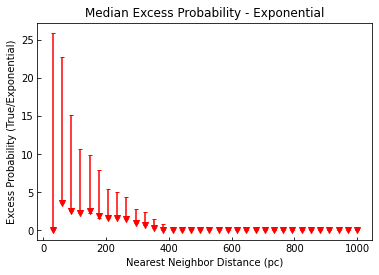

In [10]:
fig, ax=plt.subplots()
for i in range(len(exp_median[:-1])):
    ax.scatter(bins[1:][i], np.median(exp_median[i]), c='red', marker='v')
    yerr = [[np.percentile(exp_median[i], 16)],[np.percentile(exp_median[i], 84)]]
    #yerr = np.array(np.percentile(cov_median[i], 16), np.percentile(cov_median[i], 84))
    ax.errorbar(bins[1:][i], np.median(exp_median[i]), 
                 yerr=yerr, capsize=2, ecolor='red')

ax.set_xlabel('Nearest Neighbor Distance (pc)')
ax.set_ylabel('Excess Probability (True/Exponential)')
ax.tick_params(axis='both', direction='in')
ax.set_title('Median Excess Probability - Exponential')

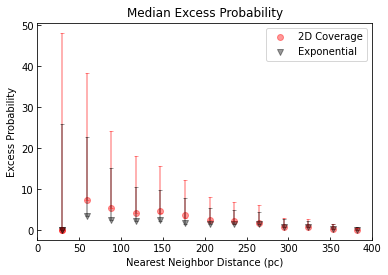

In [11]:
fig, ax=plt.subplots()
for i in range(len(exp_median[:-1])):
    if i ==0:
        ax.scatter(bins[1:][i], np.median(cov_median[i]), c='red', alpha=0.4, label='2D Coverage')
        ax.scatter(bins[1:][i], np.median(exp_median[i]), c='black', marker='v', alpha=0.4, label='Exponential')
    ax.scatter(bins[1:][i], np.median(cov_median[i]), c='red', alpha=0.4)
    yerr = [[np.percentile(cov_median[i], 16)],[np.percentile(cov_median[i], 84)]]
    #yerr = np.array(np.percentile(cov_median[i], 16), np.percentile(cov_median[i], 84))
    ax.errorbar(bins[1:][i], np.median(cov_median[i]), 
                 yerr=yerr, capsize=2, ecolor='red', alpha=0.4)
    
    ax.scatter(bins[1:][i], np.median(exp_median[i]), c='black', marker='v', alpha=0.4)
    yerr1 = [[np.percentile(exp_median[i], 16)],[np.percentile(exp_median[i], 84)]]
    #yerr = np.array(np.percentile(cov_median[i], 16), np.percentile(cov_median[i], 84))
    ax.errorbar(bins[1:][i], np.median(exp_median[i]), 
                 yerr=yerr1, capsize=2, ecolor='black', alpha=0.4)

ax.set_xlabel('Nearest Neighbor Distance (pc)')
ax.set_ylabel('Excess Probability')
ax.tick_params(axis='both', direction='in')
ax.set_title('Median Excess Probability')
ax.set_xlim(0,400)
plt.legend()

In [12]:
np.array((np.percentile(cov_median[i], 84), np.percentile(cov_median[i], 16))).shape

(2,)

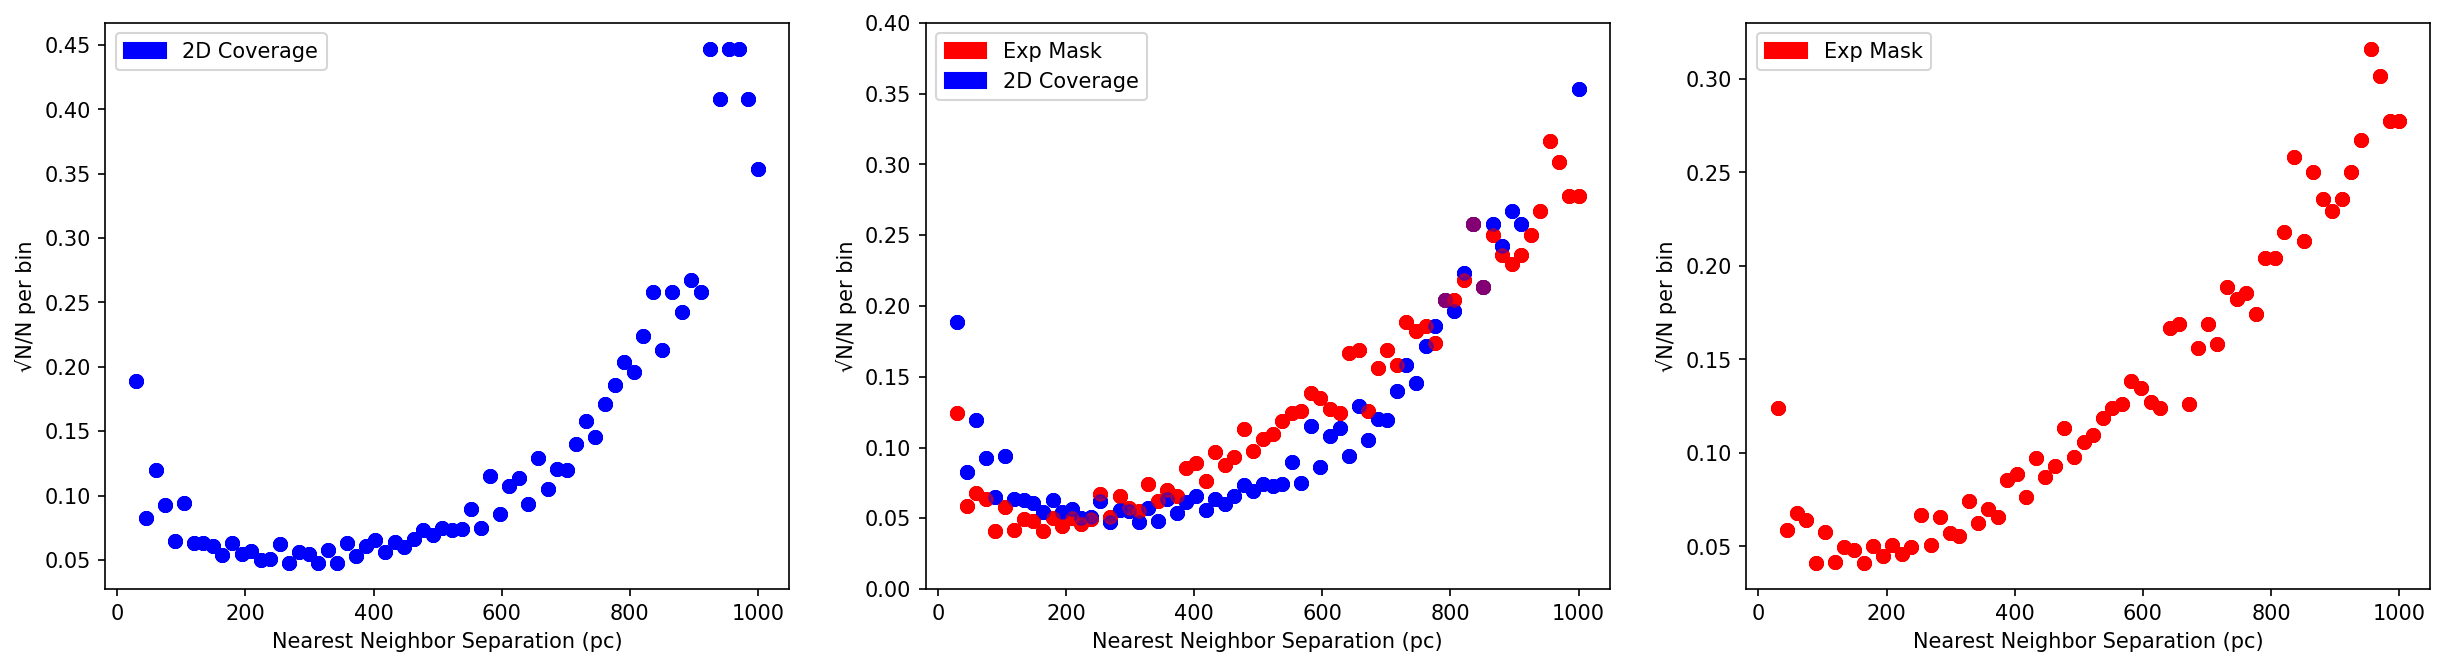

In [13]:
import warnings
warnings.filterwarnings('ignore')
red_patch = mpatches.Patch(color='red', label='Exp Mask')
blue_patch = mpatches.Patch(color='blue', label='2D Coverage')

res = res_list[0]
bins = np.linspace(0,1000,68)
fig, ax = plt.subplots(1,3, figsize=(20,5), dpi=150)
binsize = bins[1]-bins[0]
cov_med_err = [[],[]]
exp_med_err = [[],[]]

for i in range(len(sources)):
    loc = []
    i=63
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins)
            rand_cov = np.histogram(cov_dist, bins=bins)
            rand_exp = np.histogram(exp_dist, bins=bins)
            
            rand_cov_unc = np.sqrt(rand_cov[0])/rand_cov[0]
            rand_exp_unc = np.sqrt(rand_exp[0])/rand_exp[0]
            ax[0].scatter(bins[1:], rand_cov_unc, c='blue', alpha=0.1)
            ax[2].scatter(bins[1:], rand_exp_unc, c='red', alpha=0.1)
            ax[1].scatter(bins[1:], rand_cov_unc, c='blue', alpha=0.1)
            ax[1].scatter(bins[1:], rand_exp_unc, c='red', alpha=0.1)

ax[0].set_xlabel('Nearest Neighbor Separation (pc)')
ax[0].set_ylabel('\u221AN/N per bin')
ax[0].legend(handles=[blue_patch])

ax[1].set_xlabel('Nearest Neighbor Separation (pc)')
ax[1].set_ylabel('\u221AN/N per bin')
ax[1].set_ylim(0,0.4)
ax[1].legend(handles=[red_patch, blue_patch]) 

ax[2].set_xlabel('Nearest Neighbor Separation (pc)')
ax[2].set_ylabel('\u221AN/N per bin')
ax[2].legend(handles=[red_patch])

In [14]:
sources[32]

'ngc3621'

# 1e4 Median Scatter: ngc3621 60pc

In [15]:


res = res_list[3]
bins = np.linspace(0,1000,50)
#fig, ax = plt.subplots(1,3, figsize=(20,5), dpi=150)
binsize = bins[1]-bins[0]
med = []
i = 32
loc = []


data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
if os.path.isfile(data):
    cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
    if os.path.isfile(cat_2d_fp):
        cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
        cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
        real_data = pd.read_csv(data)
        col_2d = list(cat_2d.columns)
        col_exp = list(cat_exp.columns)
        real_dist = real_data['min_dist']
        exp_dist = []
        cov_dist = []
        loc_2d = []
        loc_exp = []
        for k in range(len(col_2d)):
            loc_2d.append(col_2d[k].endswith('first'))
        for k in range(len(col_exp)):
            loc_exp.append(col_exp[k].endswith('first'))
        exp_first = cat_exp.iloc[:,loc_exp]
        cov_first = cat_2d.iloc[:,loc_2d]
        for j in range(len(exp_first.columns)):
            exp_dist.extend(exp_first.iloc[:,j].tolist())
        for j in range(len(cov_first.columns)):
            cov_dist.extend(cov_first.iloc[:,j].tolist())
        
        bin_counts_exp = np.zeros(shape=(len(exp_first.columns), len(bins)-1))
        bin_counts_cov = np.zeros(shape=(len(cov_first.columns), len(bins)-1))
        for j in range(len(exp_first.columns)):
            val = np.array(exp_first.iloc[:,j])
            bin_counts_exp[j] = np.histogram(val, bins)[0]
        for j in range(len(cov_first.columns)):
            val = np.array(cov_first.iloc[:,j])
            bin_counts_cov[j] = np.histogram(val, bins)[0]


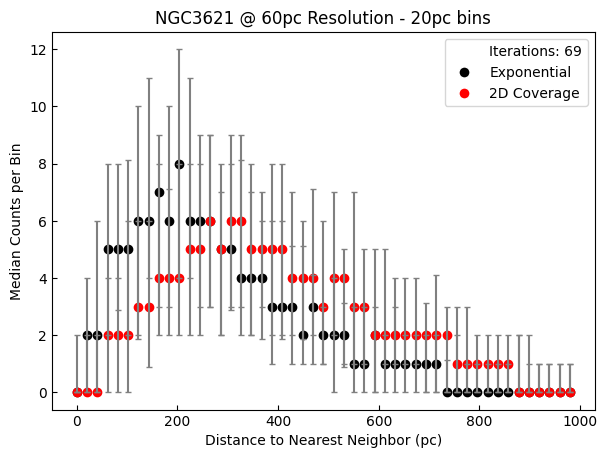

In [16]:
plt.figure(figsize=(7,5), dpi=100)


for i in range(len(bin_counts_exp[0])):
    exp_data = bin_counts_exp[:,i]
    plt.scatter(bins[i], np.median(exp_data), c='black')
    yerr = [abs(np.percentile(exp_data, 16) - np.median(exp_data))], [abs(np.percentile(exp_data, 84) - np.median(exp_data))]
    plt.errorbar(bins[i], np.median(exp_data), yerr=yerr, ecolor='grey', capsize=2)
    
    cov_data = bin_counts_cov[:,i]
    plt.scatter(bins[i], np.median(cov_data), c='red')
    yerr = [abs(np.percentile(cov_data, 16) - np.median(cov_data))], [abs(np.percentile(cov_data, 84) - np.median(cov_data))]
    plt.errorbar(bins[i], np.median(cov_data), yerr=yerr, ecolor='grey', capsize=2)


#LEGEND
iterations_label = mpatches.Patch(color='white', label='Iterations: '+str(len(bin_counts_exp)))
exp_label = Line2D([0], [0], marker='o', color='w', label='Exponential',
                          markerfacecolor='black', markersize=8)
cov_label = Line2D([0], [0], marker='o', color='w', label='2D Coverage',
                          markerfacecolor='red', markersize=8)
legend_elements = [iterations_label, exp_label, cov_label]


plt.xlabel('Distance to Nearest Neighbor (pc)')
plt.ylabel('Median Counts per Bin')
plt.title('NGC3621 @ 60pc Resolution - 20pc bins')
plt.legend(handles=legend_elements)
plt.tick_params(axis='both', direction='in')

# 1e4 Median Scatter - w/ sqrt(N)

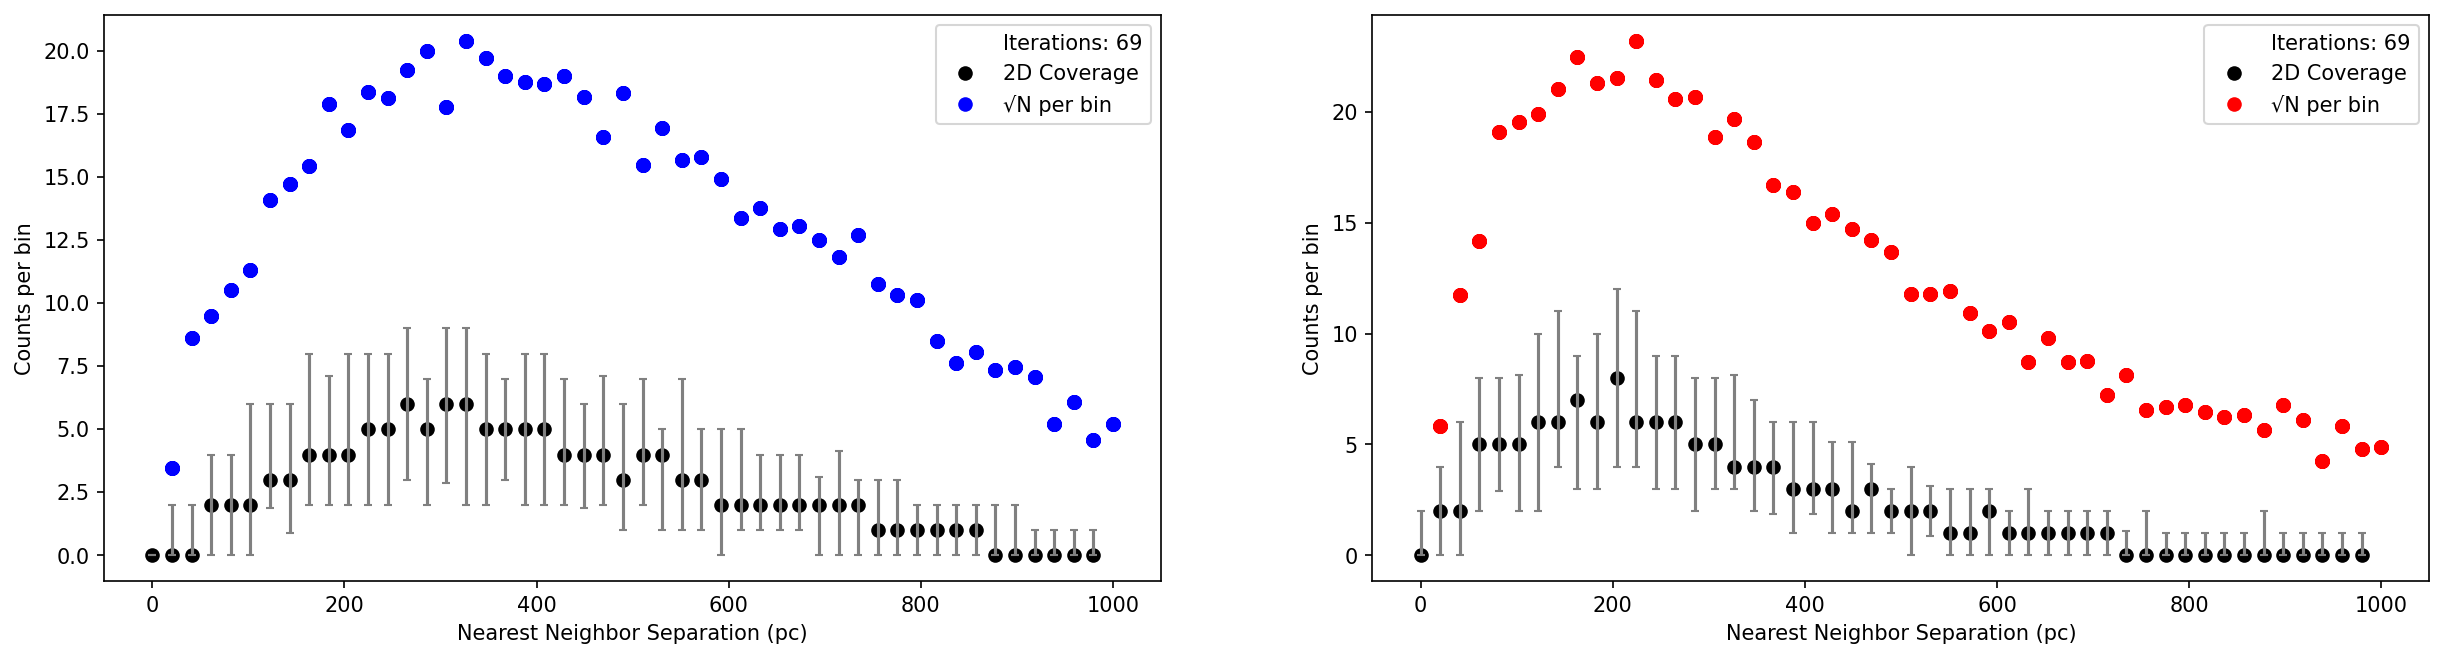

In [17]:
import warnings
warnings.filterwarnings('ignore')
red_patch = mpatches.Patch(color='red', label='Exp Mask')

res = res_list[3]
bins = np.linspace(0,1000,50)
fig, ax = plt.subplots(1,2, figsize=(20,5), dpi=150)
binsize = bins[1]-bins[0]
cov_med_err = [[],[]]
exp_med_err = [[],[]]

for i in range(len(sources)):
    loc = []
    i=32
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins)
            rand_cov = np.histogram(cov_dist, bins=bins)
            rand_exp = np.histogram(exp_dist, bins=bins)
            
            rand_cov_unc = np.sqrt(rand_cov[0])
            rand_exp_unc = np.sqrt(rand_exp[0])
            ax[0].scatter(bins[1:], rand_cov_unc, c='blue', alpha=0.1)
            ax[1].scatter(bins[1:], rand_exp_unc, c='red', alpha=0.1)
            

            
            
for i in range(len(bin_counts_cov[0])):
    cov_data = bin_counts_cov[:,i]
    ax[0].scatter(bins[i], np.median(cov_data), c='black')
    yerr = [abs(np.percentile(cov_data, 16) - np.median(cov_data))], [abs(np.percentile(cov_data, 84) - np.median(cov_data))]
    ax[0].errorbar(bins[i], np.median(cov_data), yerr=yerr, ecolor='grey', capsize=2)


iterations_label = mpatches.Patch(color='white', label='Iterations: '+str(len(bin_counts_exp)))
cov_label = Line2D([0], [0], marker='o', color='w', label='2D Coverage',
                          markerfacecolor='black', markersize=8)
rootn = Line2D([0], [0], marker='o', color='w', label='\u221AN per bin',
                          markerfacecolor='b', markersize=8)
legend_elements = [iterations_label, cov_label, rootn]    
ax[0].set_xlabel('Nearest Neighbor Separation (pc)')
ax[0].set_ylabel('Counts per bin')
ax[0].legend(handles=legend_elements)
ax[0].tick_params(axis='both')


for i in range(len(bin_counts_exp[0])):
    exp_data = bin_counts_exp[:,i]
    ax[1].scatter(bins[i], np.median(exp_data), c='black')
    yerr = [abs(np.percentile(exp_data, 16) - np.median(exp_data))], [abs(np.percentile(exp_data, 84) - np.median(exp_data))]
    ax[1].errorbar(bins[i], np.median(exp_data), yerr=yerr, ecolor='grey', capsize=2)


iterations_label = mpatches.Patch(color='white', label='Iterations: '+str(len(bin_counts_exp)))
exp_label = Line2D([0], [0], marker='o', color='w', label='Exponential',
                          markerfacecolor='black', markersize=8)
rootn = Line2D([0], [0], marker='o', color='w', label='\u221AN per bin',
                          markerfacecolor='r', markersize=8)
legend_elements = [iterations_label, cov_label, rootn] 
ax[1].set_xlabel('Nearest Neighbor Separation (pc)')
ax[1].set_ylabel('Counts per bin')
ax[1].legend(handles=legend_elements)

# error bars v rootN

Text(0.5, 0.98, 'NGC3621 - 60pc res - 1e4 Random Placements')

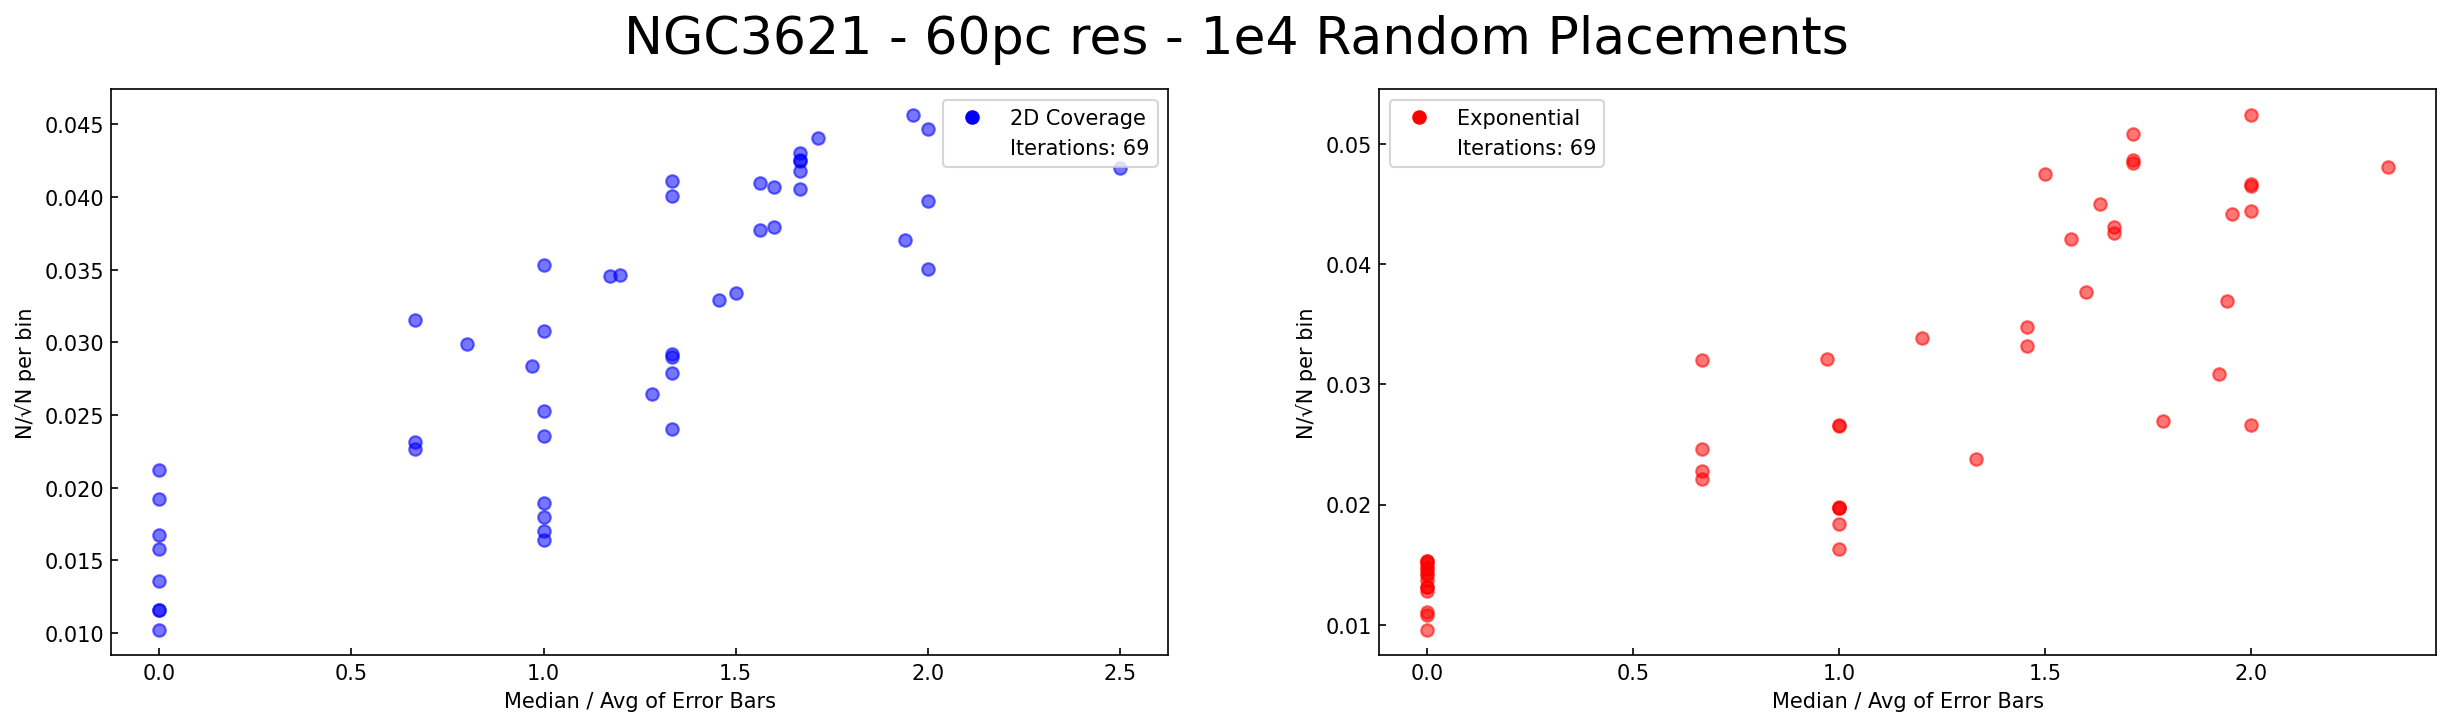

In [18]:
res = res_list[3]
bins = np.linspace(0,1000,50)
fig, ax = plt.subplots(1,2, figsize=(20,5), dpi=150)
binsize = bins[1]-bins[0]
cov_med_err = [[],[]]
exp_med_err = [[],[]]


cov_errbars = []
cov_medians = []
for i in range(len(bin_counts_cov[0])):
    cov_data = bin_counts_cov[:,i]
    med = np.median(cov_data)
    upper = abs(np.percentile(cov_data, 84) - np.median(cov_data))
    lower = abs(np.percentile(cov_data, 16) - np.median(cov_data))
    val = (upper+lower)/2
    cov_errbars.append(val)
    cov_medians.append(med)
    
exp_errbars = []
exp_medians = []
for i in range(len(bin_counts_exp[0])):
    exp_data = bin_counts_exp[:,i]
    med = np.median(exp_data)
    upper = abs(np.percentile(exp_data, 84) - np.median(exp_data))
    lower = abs(np.percentile(exp_data, 16) - np.median(exp_data))
    val = (upper+lower)/2
    exp_errbars.append(val)
    exp_medians.append(med)

cov_errbars, cov_medians = np.array(cov_errbars), np.array(cov_medians)
exp_errbars, exp_medians = np.array(exp_errbars), np.array(exp_medians)
single_source = sources[32]
for i in range(len(single_source)):
    loc = []
    i=32
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins)
            #NORMALIZED
            rand_cov = np.histogram(cov_dist, bins=bins, normed=True)
            rand_exp = np.histogram(exp_dist, bins=bins, normed=True)
            #FINDING SIGNAL VALUES FOR EACH BIN
            
            cov_signal = np.zeros(len(bins)-1)
            exp_signal = np.zeros(len(bins)-1)
            for ii in range(len(bins)-1):
                cov_bins = np.digitize(cov_dist, bins=bins)
                z = np.where(cov_bins == ii+1)
                cov_signal[ii] = len(z)
                
                exp_bins = np.digitize(exp_dist, bins=bins)
                z = np.where(exp_bins == ii+1)
                exp_signal[ii] = len(z)
         
            rand_cov_unc = cov_signal * rand_cov[0]/np.sqrt(rand_cov[0])
            rand_exp_unc = exp_signal * rand_exp[0]/np.sqrt(rand_exp[0])
            ax[0].scatter(cov_medians/cov_errbars, rand_cov_unc, c='blue', alpha=0.1)
            ax[1].scatter(exp_medians/exp_errbars, rand_exp_unc, c='red', alpha=0.1)

            
            
iterations_label = mpatches.Patch(color='white', label='Iterations: '+str(len(bin_counts_exp)))
cov_label = Line2D([0], [0], marker='o', color='w', label='2D Coverage',
                          markerfacecolor='b', markersize=8)
rootn = Line2D([0], [0], marker='o', color='w', label='\u221AN per bin',
                          markerfacecolor='b', markersize=8)
legend_elements = [cov_label, iterations_label]    
ax[0].set_ylabel('N/\u221AN per bin')
ax[0].set_xlabel('Median / Avg of Error Bars')
ax[0].legend(handles=legend_elements)
ax[0].tick_params(axis='both', direction='in')




iterations_label = mpatches.Patch(color='white', label='Iterations: '+str(len(bin_counts_exp)))
exp_label = Line2D([0], [0], marker='o', color='w', label='Exponential',
                          markerfacecolor='r', markersize=8)
rootn = Line2D([0], [0], marker='o', color='w', label='\u221AN per bin',
                          markerfacecolor='r', markersize=8)
legend_elements = [exp_label, iterations_label]    
ax[1].set_ylabel('N/\u221AN per bin')
ax[1].set_xlabel('Median / Avg of Error Bars')
ax[1].legend(handles=legend_elements)
ax[1].tick_params(axis='both', direction='in')
fig.suptitle('NGC3621 - 60pc res - 1e4 Random Placements', fontsize=25)

In [19]:
cov_signal

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
cat_2d_fp

'/data/rubin/machado.35/phangs/rand_results/ngc3621_1e4_2dcov_150pc.csv'

In [21]:
for ii in range(len(bins)-1):
                cov_bins = np.digitize(cov_dist, bins=bins)
                z = np.where(cov_bins == ii+1)
                cov_signal[ii] = np.median(np.array(cov_dist)[z])
                
                exp_bins = np.digitize(exp_dist, bins=bins)
                z = np.where(exp_bins == ii+1)
                exp_signal[ii] = np.median(np.array(exp_dist)[z])

In [22]:
cov_bins = np.digitize(cov_dist, bins=bins)

In [23]:
z = np.where(cov_bins == 2)

In [24]:
exp_medians

array([0., 2., 2., 5., 5., 5., 6., 6., 7., 6., 8., 6., 6., 6., 5., 5., 4.,
       4., 4., 3., 3., 3., 2., 3., 2., 2., 2., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
np.median(np.array(cov_dist)[z])

31.91275147102401

In [ ]:
res = res_list[3]
bins = np.linspace(0,1000,50)
#fig, ax = plt.subplots(1,3, figsize=(20,5), dpi=150)
binsize = bins[1]-bins[0]
med = []
i = 32
loc = []


data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
if os.path.isfile(data):
    cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
    if os.path.isfile(cat_2d_fp):
        cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
        cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
        real_data = pd.read_csv(data)
        col_2d = list(cat_2d.columns)
        col_exp = list(cat_exp.columns)
        real_dist = real_data['min_dist']
        exp_dist = []
        cov_dist = []
        loc_2d = []
        loc_exp = []
        for k in range(len(col_2d)):
            loc_2d.append(col_2d[k].endswith('first'))
        for k in range(len(col_exp)):
            loc_exp.append(col_exp[k].endswith('first'))
        exp_first = cat_exp.iloc[:,loc_exp]
        cov_first = cat_2d.iloc[:,loc_2d]
        for j in range(len(exp_first.columns)):
            exp_dist.extend(exp_first.iloc[:,j].tolist())
        for j in range(len(cov_first.columns)):
            cov_dist.extend(cov_first.iloc[:,j].tolist())
        
        bin_counts_exp = np.zeros(shape=(len(exp_first.columns), len(bins)-1))
        bin_counts_cov = np.zeros(shape=(len(cov_first.columns), len(bins)-1))
        for j in range(len(exp_first.columns)):
            val = np.array(exp_first.iloc[:,j])
            bin_counts_exp[j] = np.histogram(val, bins)[0]
        for j in range(len(cov_first.columns)):
            val = np.array(cov_first.iloc[:,j])
            bin_counts_cov[j] = np.histogram(val, bins)[0]

Text(0.5, 0.98, 'NGC3621 - 60pc res - 1e4 Random Placements')

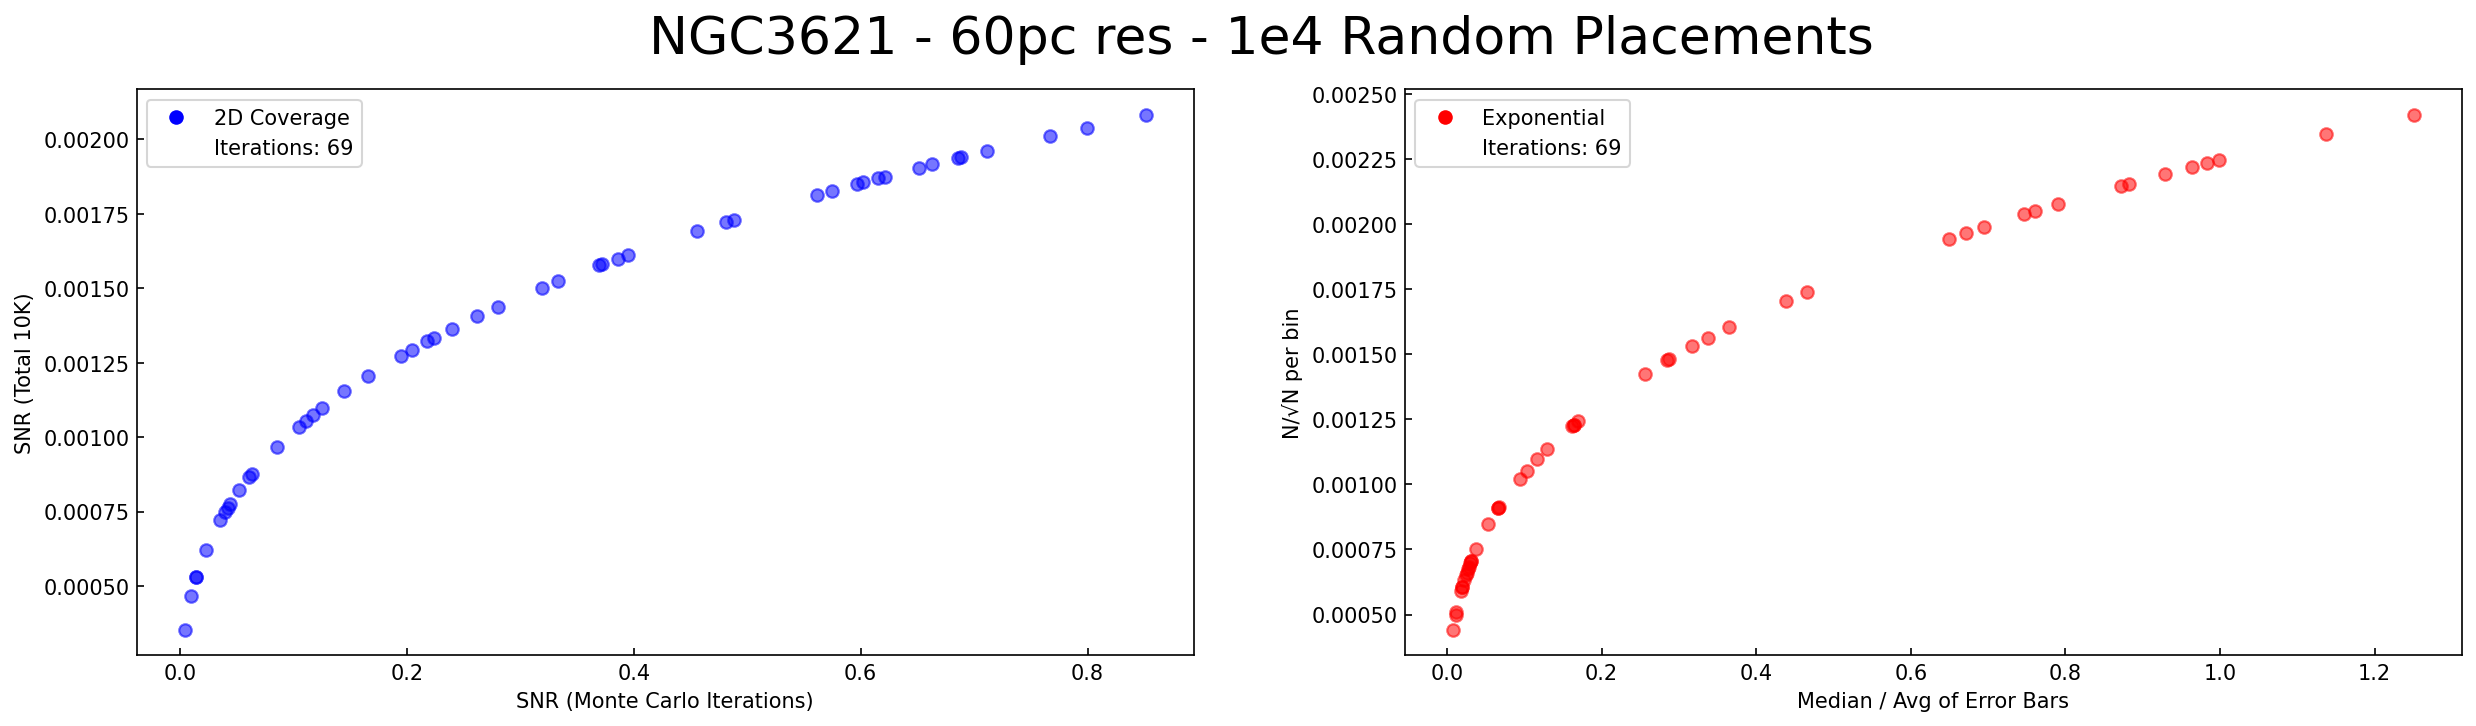

In [38]:
res = res_list[3]
bins = np.linspace(0,1000,50)
fig, ax = plt.subplots(1,2, figsize=(20,5), dpi=150)
binsize = bins[1]-bins[0]
cov_med_err = [[],[]]
exp_med_err = [[],[]]


cov_errbars = []
cov_medians = []
for i in range(len(bin_counts_cov[0])):
    cov_data = bin_counts_cov[:,i]
    med = np.median(cov_data)
    upper = abs(np.percentile(cov_data, 84) - np.median(cov_data))
    lower = abs(np.percentile(cov_data, 16) - np.median(cov_data))
    val = (upper+lower)/2
    cov_errbars.append(val)
    cov_medians.append(med)
    
exp_errbars = []
exp_medians = []
for i in range(len(bin_counts_exp[0])):
    exp_data = bin_counts_exp[:,i]
    med = np.median(exp_data)
    upper = abs(np.percentile(exp_data, 84) - np.median(exp_data))
    lower = abs(np.percentile(exp_data, 16) - np.median(exp_data))
    val = (upper+lower)/2
    exp_errbars.append(val)
    exp_medians.append(med)

cov_errbars, cov_medians = np.array(cov_errbars), np.array(cov_medians)
exp_errbars, exp_medians = np.array(exp_errbars), np.array(exp_medians)
single_source = sources[32]
for i in range(len(single_source)):
    loc = []
    i=32
    data = '/home/machado.35/projects/intro/sources/'+sources[i]+'/'+sources[i]+'_'+str(res)+'pc_cloud_stats.csv'
    if os.path.isfile(data):
        cat_2d_fp = fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv'
        if os.path.isfile(cat_2d_fp):
            cat_2d = pd.read_csv(fp+sources[i]+'_1e4_2dcov_'+str(res)+'pc.csv')
            cat_exp = pd.read_csv(fp+sources[i]+'_1e4_exp_'+str(res)+'pc.csv')
            real_data = pd.read_csv(data)
            col_2d = list(cat_2d.columns)
            col_exp = list(cat_exp.columns)
            real_dist = real_data['min_dist']
            exp_dist = []
            cov_dist = []
            loc_2d = []
            loc_exp = []
            for k in range(len(col_2d)):
                loc_2d.append(col_2d[k].endswith('first'))
            for k in range(len(col_exp)):
                loc_exp.append(col_exp[k].endswith('first'))
            exp_first = cat_exp.iloc[:,loc_exp]
            cov_first = cat_2d.iloc[:,loc_2d]
            for j in range(len(exp_first.columns)):
                exp_dist.extend(exp_first.iloc[:,j].tolist())
            for j in range(len(cov_first.columns)):
                cov_dist.extend(cov_first.iloc[:,j].tolist())
            true = np.histogram(real_dist, bins=bins)

            rand_cov = np.histogram(cov_dist, bins=bins, normed=False)
            rand_exp = np.histogram(exp_dist, bins=bins, normed=False)
            #FINDING SIGNAL VALUES FOR EACH BIN
            
            cov_signal = np.zeros(len(bins)-1)
            exp_signal = np.zeros(len(bins)-1)
            for ii in range(len(bins)-1):
                cov_bins = np.digitize(cov_dist, bins=bins)
                z = np.where(cov_bins == ii+1)
                cov_signal[ii] = len(z)
                
                exp_bins = np.digitize(exp_dist, bins=bins)
                z = np.where(exp_bins == ii+1)
                exp_signal[ii] = len(z)
         
            rand_cov_unc = (rand_cov[0] / np.sum(rand_cov[0]))/np.sqrt(rand_cov[0])
            rand_exp_unc = (rand_exp[0] / np.sum(rand_exp[0]))/np.sqrt(rand_exp[0])
            
            
            #### SNR FOR TOTAL 1e4 RANDOM PLACEMENTS
            
            
            Ntot = np.sum(rand_cov[0]) #TOTAL NUMBER OF COUNTS ~10K
            total_signal_cov = rand_cov[0] / Ntot #rand_cov[0] = counts per bin
            total_noise_cov = 1/np.sqrt(rand_cov[0])
            total_SNR_cov = total_signal_cov/total_noise_cov
            
            #TOTAL SIGNAL is counts per bin / total counts in histogram
            #TOTAL NOISE is 1/sqrt(N) for each bin
                                        
            total_signal_exp = rand_exp[0] / np.sum(exp_dist)
            total_noise_exp = 1/np.sqrt(rand_exp[0])
            total_SNR_exp = total_signal_exp/total_noise_exp
            
            #### SNR FOR MONTE CARLO (OVER X ITERATIONS OF RANDOM PLACEMENT LOOP)

            mc_signal_cov = 
            mc_noise_cov = 
            mc_SNR_cov = mc_signal_cov/mc_noise_cov
            
            
            mc_signal_exp = 
            mc_noise_exp = 
            mc_SNR_exp = mc_signal_exp/mc_noise_exp
            
            #MONTE CARLO SIGNAL: find counts per bin for each iteration and use median of that data set
            #MONTE CARLO NOISE is scatter in counts per bin over every iteration
            
            ax[0].scatter(total_SNR_cov, rand_cov_unc, c='blue', alpha=0.1)
            ax[1].scatter(total_SNR_exp, rand_exp_unc, c='red', alpha=0.1)

            
            
iterations_label = mpatches.Patch(color='white', label='Iterations: '+str(len(bin_counts_exp)))
cov_label = Line2D([0], [0], marker='o', color='w', label='2D Coverage',
                          markerfacecolor='b', markersize=8)
rootn = Line2D([0], [0], marker='o', color='w', label='\u221AN per bin',
                          markerfacecolor='b', markersize=8)
legend_elements = [cov_label, iterations_label]    
ax[0].set_ylabel('SNR (Total 10K)')
ax[0].set_xlabel('SNR (Monte Carlo Iterations)')
ax[0].legend(handles=legend_elements)
ax[0].tick_params(axis='both', direction='in')





legend_elements = [exp_label, iterations_label]    
ax[1].set_ylabel('N/\u221AN per bin')
ax[1].set_xlabel('Median / Avg of Error Bars')
ax[1].legend(handles=legend_elements)
ax[1].tick_params(axis='both', direction='in')
fig.suptitle('NGC3621 - 60pc res - 1e4 Random Placements', fontsize=25)

In [39]:
total_signal_cov

array([0.0011994 , 0.0073963 , 0.0089955 , 0.01109445, 0.0127936 ,
       0.01989005, 0.02168916, 0.02388806, 0.03208396, 0.02848576,
       0.03378311, 0.03288356, 0.03698151, 0.03998001, 0.03158421,
       0.04167916, 0.03888056, 0.03608196, 0.03528236, 0.03488256,
       0.03618191, 0.03308346, 0.02748626, 0.03358321, 0.02398801,
       0.02878561, 0.02458771, 0.02498751, 0.02228886, 0.01789105,
       0.0189905 , 0.0167916 , 0.01709145, 0.0155922 , 0.013993  ,
       0.01609195, 0.0115942 , 0.01069465, 0.01029485, 0.0071964 ,
       0.0057971 , 0.00649675, 0.0053973 , 0.0055972 , 0.0049975 ,
       0.00269865, 0.00369815, 0.00209895, 0.00269865])

In [46]:
bin_counts_cov[0]

array([2., 0., 4., 4., 0., 2., 0., 4., 2., 0., 5., 2., 7., 4., 1., 2., 9.,
       4., 6., 9., 7., 7., 4., 6., 2., 2., 5., 6., 8., 1., 6., 0., 3., 2.,
       0., 0., 3., 1., 0., 4., 2., 0., 1., 3., 1., 1., 0., 0., 1.])

In [47]:
exp_first.columns

Index(['run_0_first', 'run_1_first', 'run_2_first', 'run_3_first',
       'run_4_first', 'run_5_first', 'run_6_first', 'run_7_first',
       'run_8_first', 'run_9_first', 'run_10_first', 'run_11_first',
       'run_12_first', 'run_13_first', 'run_14_first', 'run_15_first',
       'run_16_first', 'run_17_first', 'run_18_first', 'run_19_first',
       'run_20_first', 'run_21_first', 'run_22_first', 'run_23_first',
       'run_24_first', 'run_25_first', 'run_26_first', 'run_27_first',
       'run_28_first', 'run_29_first', 'run_30_first', 'run_31_first',
       'run_32_first', 'run_33_first', 'run_34_first', 'run_35_first',
       'run_36_first', 'run_37_first', 'run_38_first', 'run_39_first',
       'run_40_first', 'run_41_first', 'run_42_first', 'run_43_first',
       'run_44_first', 'run_45_first', 'run_46_first', 'run_47_first',
       'run_48_first', 'run_49_first', 'run_50_first', 'run_51_first',
       'run_52_first', 'run_53_first', 'run_54_first', 'run_55_first',
       'run_56_f